Contrast modulations
====================

Multiprimary devices with good linearity, high resolution and rapid spectral switching capability may be used to present temporal modulations of photoreceptor-targeted contrast. Such stimuli have helped to shed light on how the pupil responds to input from different photoreceptors as a function of time (e.g., [Barrionuevo et al., 2016](https://jov.arvojournals.org/article.aspx?articleid=2565122); [Spitschan et al., 2014](https://www.pnas.org/doi/10.1073/pnas.1400942111)). 

To make contrast modulations, first define a stimulus profile with a sampling frequency in line with the switching capability of the stimulation device. In this case, its a 1 Hz sinusoid with 50 samples per cycle.


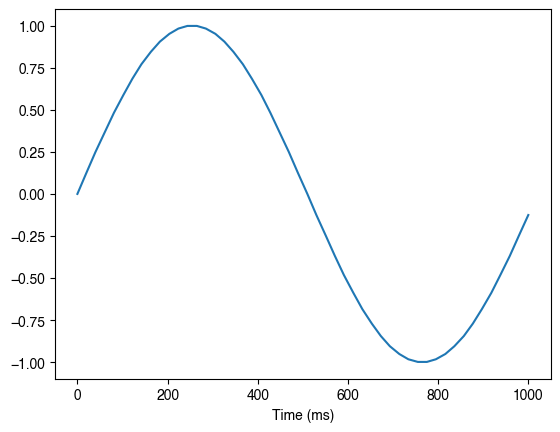

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sinusoid_modulation(f, duration, Fs=50):
    """Generate a sinusoidal waveform"""
    x = np.arange(duration * Fs)
    return np.sin(2 * np.pi * f * x / Fs)

stimulus_profile = sinusoid_modulation(1, 1)
time = np.linspace(0, 1000, 50).astype('int')

plt.plot(time, stimulus_profile)
plt.xlabel('Time (ms)');

Now, define a problem. Here we define the background spectrum as all primaries at half-max power so we can maximise bidirectional contrast. Then we say that we want to ignore rods, minimize contrast on M-cones, L-cones and melanopsin, and modulate the S-cones.

In [6]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

# Load some example data for a 10-primary system
ssp = SSP.from_package_data('STLAB_1_York')

ssp.background = [.5] * ssp.nprimaries
ssp.ignore = ['rh']
ssp.minimize = ['mc', 'lc', 'mel']
ssp.modulate = ['sc']
ssp.print_problem()

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Ignoring: ['rh']
Minimising: ['mc', 'lc', 'mel']
Modulating: ['sc']
Target contrast: None
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]




Next, choose a peak contrast value that is known to be in gamut and solve for each point in the stimulus profile. The algebraic approach is well suited here as it guarantees a linear uni-directional scaling of the primaries and is less computationally expensive than optimisation. 

In [7]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

Plotting the forward projection of contrast for each solution in this case reveals a smooth S-cone modulation with little contrast splatter on the other photoreceptors.

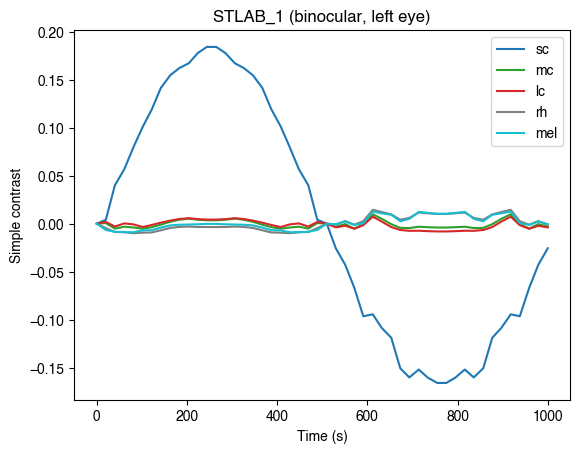

In [9]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.observer.photoreceptor_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

Finally, convert the solutions to settings compatible with the native resolution of the stimulation device.

In [11]:
device_settings = [ssp.w2s(s) for s in solutions]
device_settings = pd.DataFrame(device_settings, index=time)
with pd.option_context('display.max_rows', 10):
    print(device_settings)

         0     1     2     3     4     5     6     7     8     9
0     2047  2047  2047  2047  2047  2047  2047  2047  2047  2047
20    2145  2145  2030  2000  1965  2038  2095  2038  1997  2025
40    2241  2242  2013  1954  1885  2028  2141  2029  1947  2004
61    2334  2336  1996  1909  1807  2019  2187  2021  1899  1983
81    2422  2425  1980  1866  1733  2011  2230  2013  1853  1963
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
918   1589  1586  2128  2267  2430  2091  1824  2089  2284  2150
938   1672  1669  2114  2228  2361  2083  1864  2081  2241  2131
959   1760  1758  2098  2185  2287  2075  1907  2073  2195  2111
979   1853  1852  2081  2140  2209  2066  1953  2065  2147  2090
1000  1949  1949  2064  2094  2129  2056  1999  2056  2097  2069

[50 rows x 10 columns]


Now you just need to tell the stimulation device to set the primary inputs to these values at the specified timepoints and it will produce the S-cone modulation shown above. 

Note that with this method one can also modulate multiple photoreceptors together.

In [12]:
ssp.ignore = ['rh']
ssp.minimize = ['mel']
ssp.modulate = ['sc', 'mc', 'lc']

In [13]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

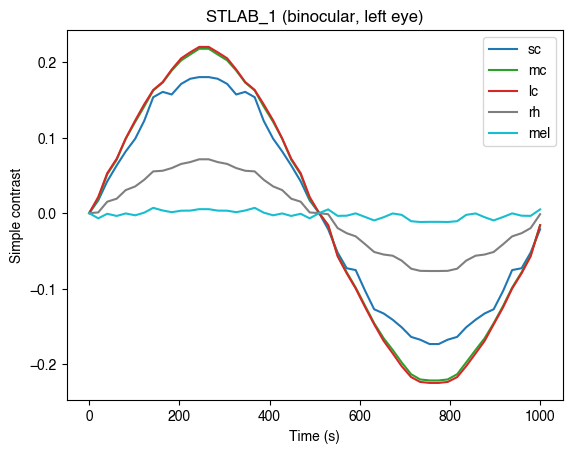

In [14]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.observer.photoreceptor_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

We can even modulate photoreceptors in counterphase.

In [15]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    c = point * peak_contrast
    ssp.target_contrast = [-c, c, c]
    solutions.append(ssp.linalg_solve())

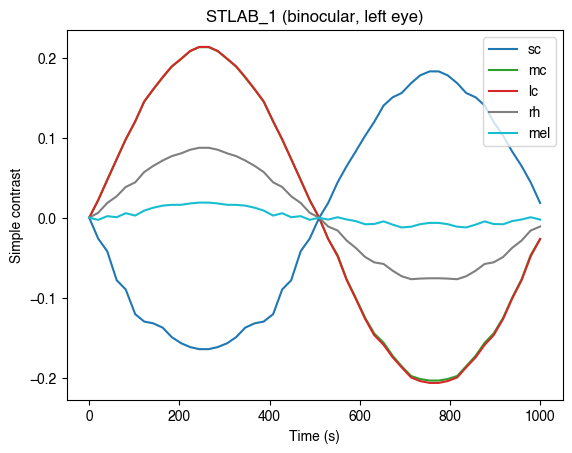

In [16]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.observer.photoreceptor_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();